# Creating Realistic Images with GANs: A Deep Learning Challenge

This notebook implements a Generative Adversarial Network (GAN) to create realistic images. GANs consist of two neural networks that compete against each other:

1. **Generator**: Creates fake images from random noise
2. **Discriminator**: Tries to distinguish between real and fake images

Through this adversarial training process, the generator gradually learns to create more realistic images.

## 1. Import Required Libraries

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import fashion_mnist

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-08-01 14:53:40.819634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754060020.844949    1116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754060020.852965    1116 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2


## 2. Load and Preprocess Dataset

For this example, we'll use the Fashion MNIST dataset, which contains 70,000 grayscale images of fashion items (clothing, shoes, bags, etc.) in 10 categories. Each image is 28x28 pixels.

I0000 00:00:1754060025.496197    1116 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754060025.496938    1116 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


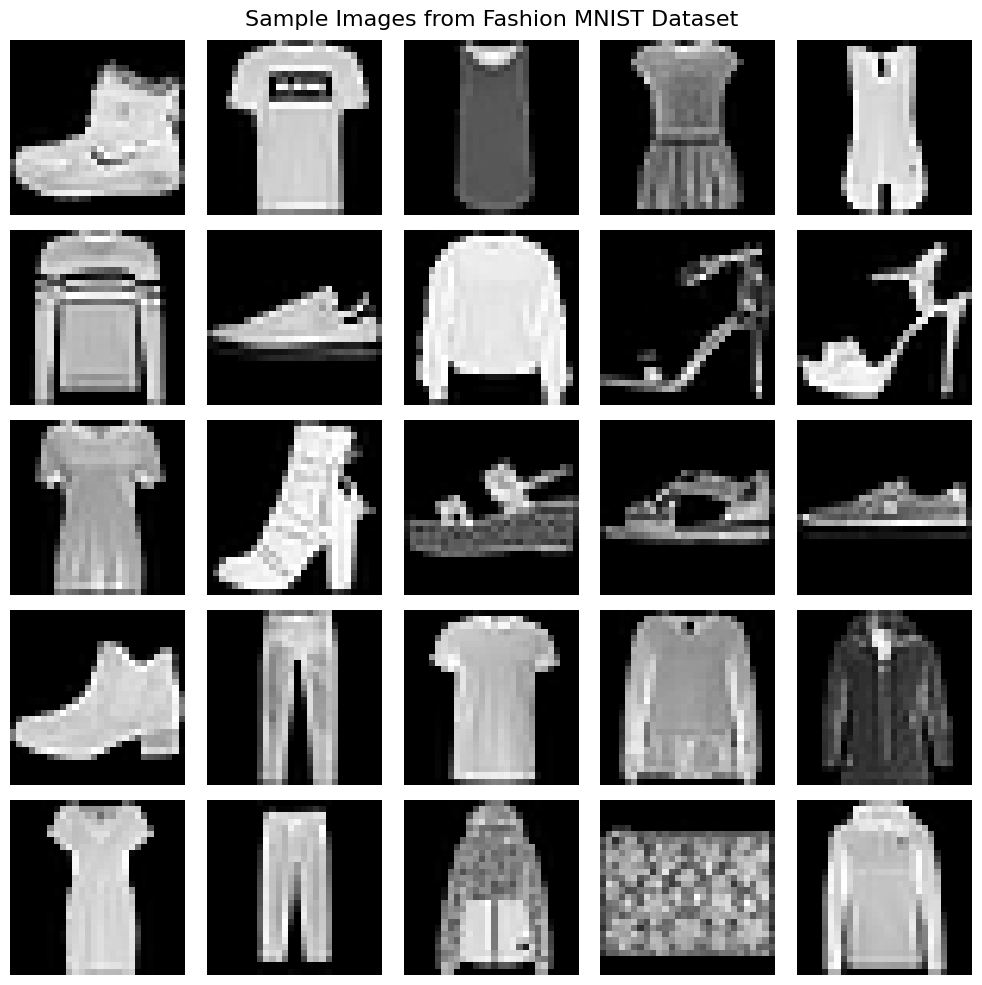

In [2]:
# Load Fashion MNIST dataset
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

# Preprocess the data
# Reshape images to add channel dimension (28x28x1)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize pixel values to [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Create TensorFlow dataset
BUFFER_SIZE = 60000  # Size of the training dataset
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Preview some images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Images from Fashion MNIST Dataset', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Define Generator Model

The generator takes a random noise vector and transforms it into an image. It uses upsampling layers to increase the spatial dimensions from the initial noise vector to the final image size.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754060028.589720    1116 cuda_dnn.cc:529] Loaded cuDNN version 90300


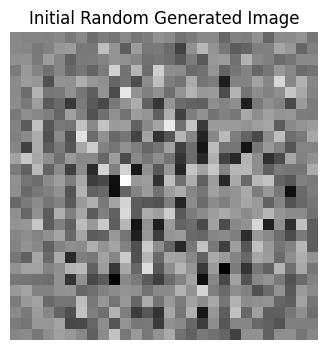

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [3]:
def make_generator_model():
    """Create the generator model to transform noise into images"""
    
    # Noise vector input dimension
    NOISE_DIM = 100
    
    model = models.Sequential()
    
    # First layer - Dense layer to reshape noise
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Reshape to start the convolutional layers
    model.add(layers.Reshape((7, 7, 256)))
    
    # First upsampling block: 7x7 -> 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second upsampling block: 14x14 -> 14x14
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Final upsampling block: 14x14 -> 28x28 with single channel (grayscale)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

# Create the generator
generator = make_generator_model()

# Test the generator with random noise
NOISE_DIM = 100
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)

# Display a sample generated image
plt.figure(figsize=(4, 4))
plt.imshow(generated_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.title('Initial Random Generated Image')
plt.show()

# Display the generator architecture
generator.summary()

## 4. Define Discriminator Model

The discriminator is a binary classifier that tries to distinguish between real images from the dataset and fake images created by the generator.

In [4]:
def make_discriminator_model():
    """Create the discriminator model to classify images as real or fake"""
    
    model = models.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                           input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second convolutional block
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Flatten and output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # No activation - we'll use sigmoid in the loss function
    
    return model

# Create the discriminator
discriminator = make_discriminator_model()

# Test the discriminator with a real image and the previously generated image
decision_real = discriminator(tf.expand_dims(train_images[0], 0), training=False)
decision_fake = discriminator(generated_image, training=False)

print(f"Discriminator output for real image: {decision_real.numpy()[0,0]}")
print(f"Discriminator output for fake image: {decision_fake.numpy()[0,0]}")

# Display the discriminator architecture
discriminator.summary()

Discriminator output for real image: -0.001737033948302269
Discriminator output for fake image: 0.0013915922027081251


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Configure GAN Model

Now we'll define the loss functions and optimizers for both the generator and discriminator networks.

In [5]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    """Calculate the discriminator loss
    
    The discriminator wants to maximize log(D(x)) + log(1 - D(G(z)))
    Which is equivalent to minimizing the negative of that expression
    """
    # Real images should be classified as 1
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    
    # Fake images should be classified as 0
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    # Total loss is the sum of both
    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake_output):
    """Calculate the generator loss
    
    The generator wants to minimize log(1 - D(G(z)))
    Which is equivalent to maximizing log(D(G(z)))
    """
    # The generator wants the discriminator to classify fake images as 1
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the noise dimension used for generating images
NOISE_DIM = 100

## 6. Create Training Loop

Here we implement the adversarial training loop where the generator and discriminator train simultaneously. First, we'll define the training step and then the full training function.

In [6]:
# Create a directory to save generated images
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

# Create a function to generate and save images
def generate_and_save_images(model, epoch, test_input, save_path=None):
    """Generate images from the model and optionally save them"""
    # Generate images
    predictions = model(test_input, training=False)
    
    # Plot the generated images
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.suptitle(f'Generated Images at Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    
    # Save if a path is provided
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    plt.close()
    
    return predictions

# Create a checkpoint manager to save model checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [7]:
# Define the training step as a TensorFlow function for better performance
@tf.function
def train_step(images):
    """Perform one training step on a batch of real images"""
    # Generate random noise for the generator
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)
        
        # Get discriminator predictions for both real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Define the training function
def train(dataset, epochs, save_interval=10):
    """Train the GAN for the specified number of epochs"""
    # Create fixed noise vectors for visualization
    seed = tf.random.normal([16, NOISE_DIM])
    
    # Lists to track losses
    gen_losses = []
    disc_losses = []
    
    # Training loop
    for epoch in range(epochs):
        start = time.time()
        
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        num_batches = 0
        
        # Train on each batch
        for image_batch in dataset:
            batch_gen_loss, batch_disc_loss = train_step(image_batch)
            epoch_gen_loss += batch_gen_loss
            epoch_disc_loss += batch_disc_loss
            num_batches += 1
        
        # Calculate average losses for the epoch
        epoch_gen_loss /= num_batches
        epoch_disc_loss /= num_batches
        
        # Add to loss history
        gen_losses.append(epoch_gen_loss)
        disc_losses.append(epoch_disc_loss)
        
        # Print progress
        print(f'Epoch {epoch+1}/{epochs}, Time: {time.time()-start:.2f}s')
        print(f'Generator Loss: {epoch_gen_loss:.4f}, Discriminator Loss: {epoch_disc_loss:.4f}')
        
        # Save checkpoint every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        # Generate and save images at regular intervals
        if (epoch + 1) % save_interval == 0 or epoch == 0 or epoch == epochs - 1:
            save_path = f'generated_images/epoch_{epoch+1:04d}.png'
            generate_and_save_images(generator, epoch + 1, seed, save_path)
    
    # Return loss history for plotting
    return np.array(gen_losses), np.array(disc_losses)

## 7. Train the GAN

Now let's train the GAN model. This will take some time depending on your hardware. We'll save images at regular intervals to track the progress.

E0000 00:00:1754060033.182499    1116 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/50, Time: 20.64s
Generator Loss: 0.7958, Discriminator Loss: 1.0769


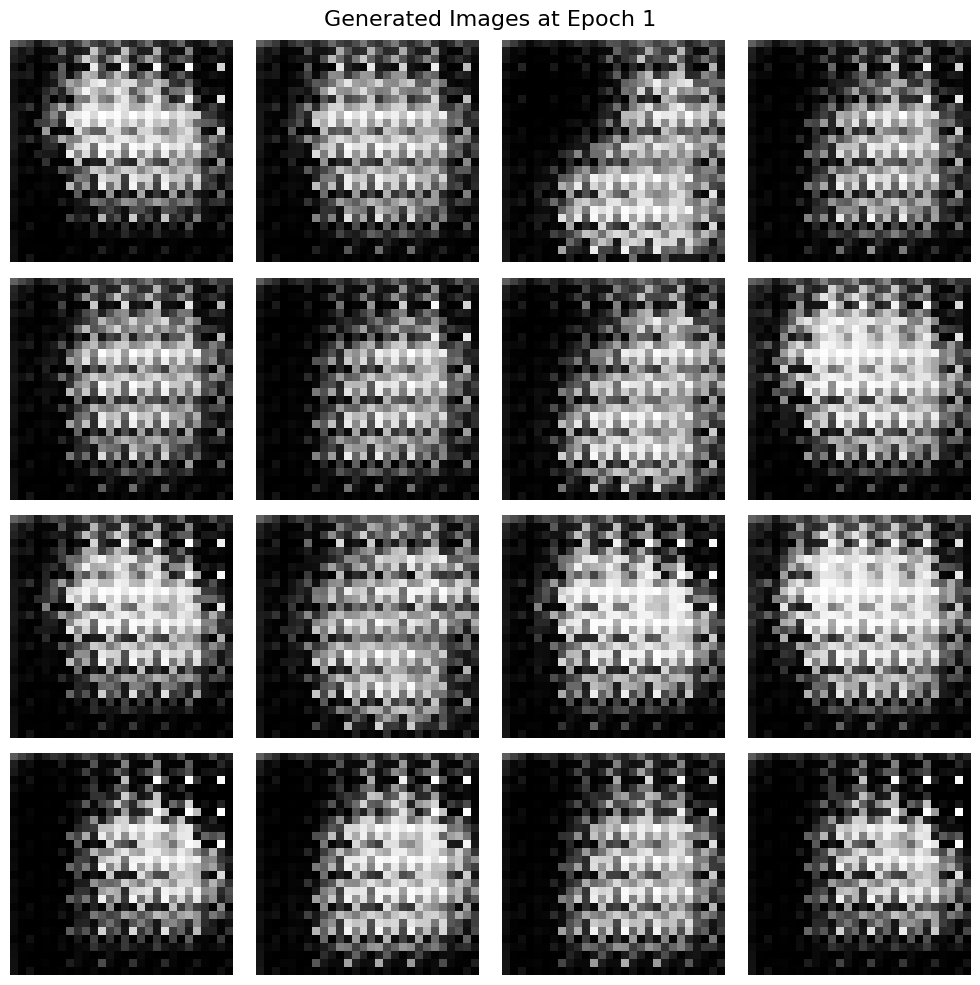

Epoch 2/50, Time: 12.48s
Generator Loss: 0.9550, Discriminator Loss: 1.1886
Epoch 3/50, Time: 12.67s
Generator Loss: 0.8456, Discriminator Loss: 1.2944
Epoch 4/50, Time: 12.76s
Generator Loss: 0.8422, Discriminator Loss: 1.2926
Epoch 5/50, Time: 12.76s
Generator Loss: 0.8000, Discriminator Loss: 1.3350


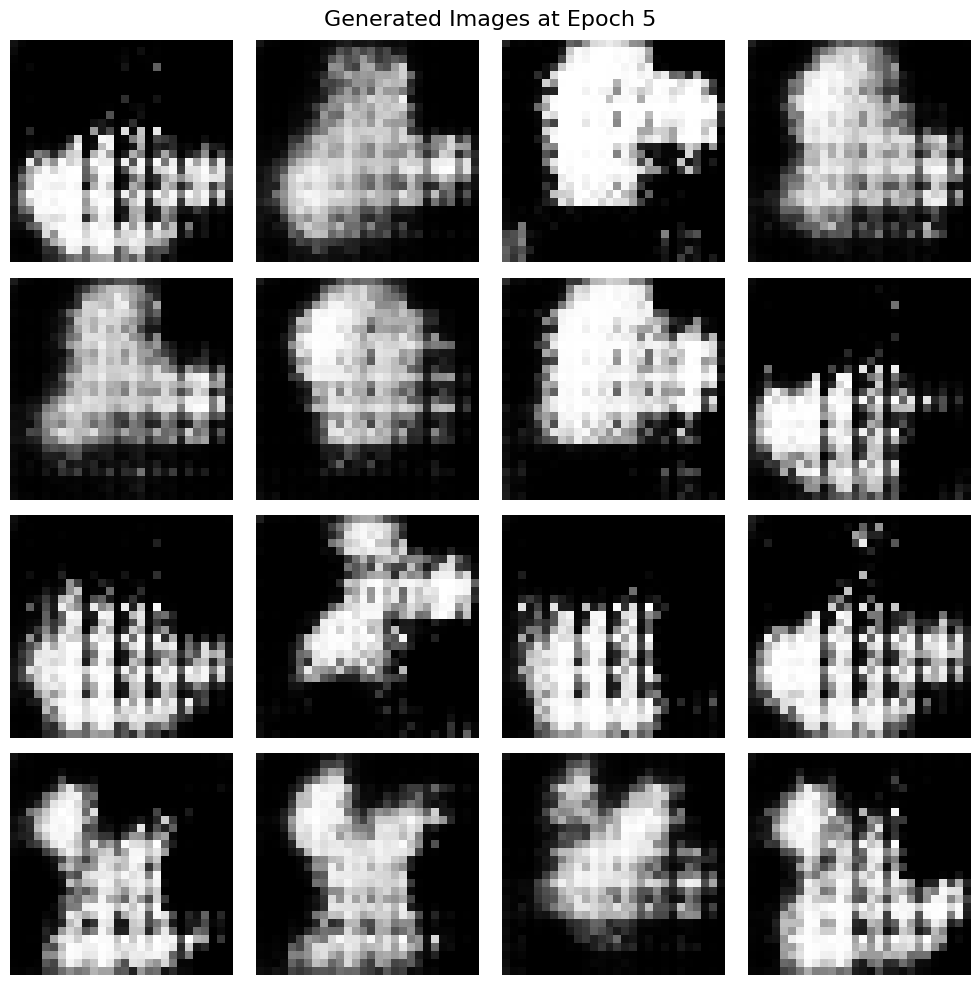

Epoch 6/50, Time: 12.61s
Generator Loss: 0.8153, Discriminator Loss: 1.3141
Epoch 7/50, Time: 12.52s
Generator Loss: 0.8903, Discriminator Loss: 1.2092
Epoch 8/50, Time: 12.50s
Generator Loss: 0.8229, Discriminator Loss: 1.3136
Epoch 9/50, Time: 12.53s
Generator Loss: 0.7799, Discriminator Loss: 1.3327
Epoch 10/50, Time: 12.55s
Generator Loss: 0.8706, Discriminator Loss: 1.2802


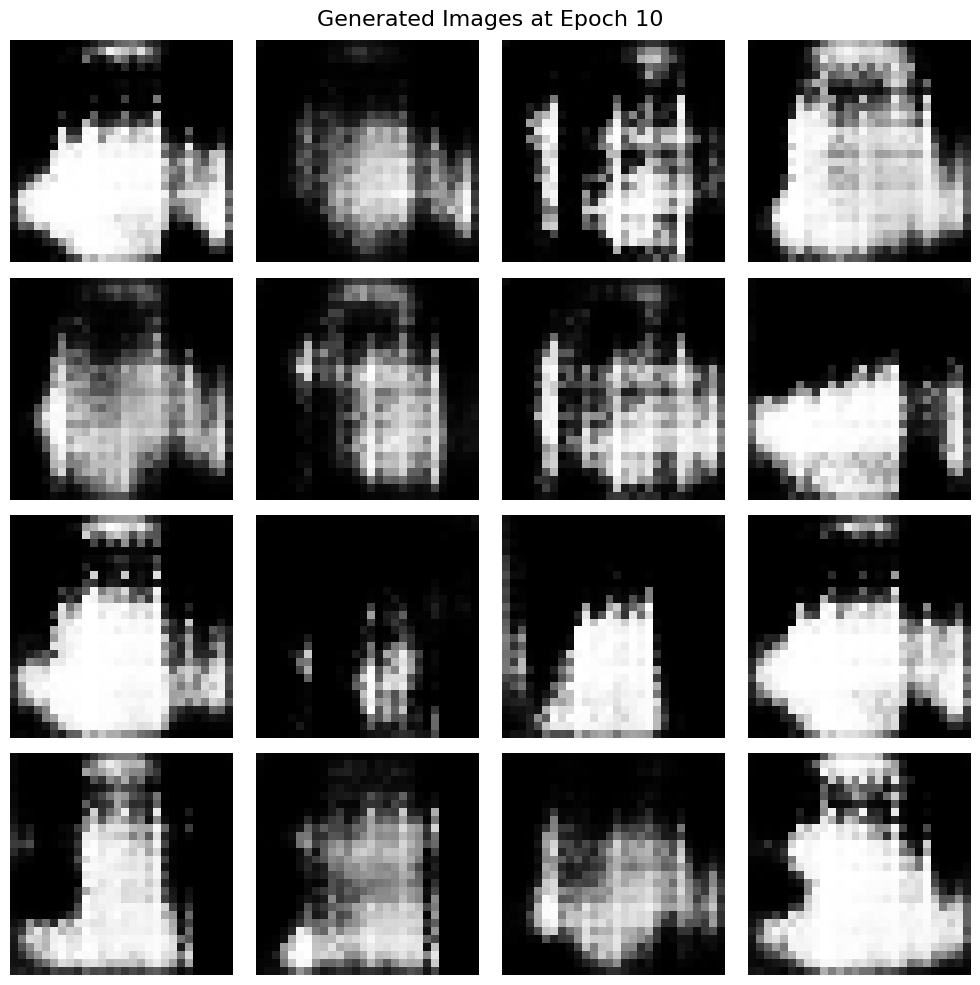

Epoch 11/50, Time: 12.65s
Generator Loss: 0.9622, Discriminator Loss: 1.1810
Epoch 12/50, Time: 12.69s
Generator Loss: 0.9823, Discriminator Loss: 1.1942
Epoch 13/50, Time: 12.68s
Generator Loss: 0.9562, Discriminator Loss: 1.1995
Epoch 14/50, Time: 12.60s
Generator Loss: 1.0257, Discriminator Loss: 1.1256
Epoch 15/50, Time: 12.53s
Generator Loss: 0.9939, Discriminator Loss: 1.1844


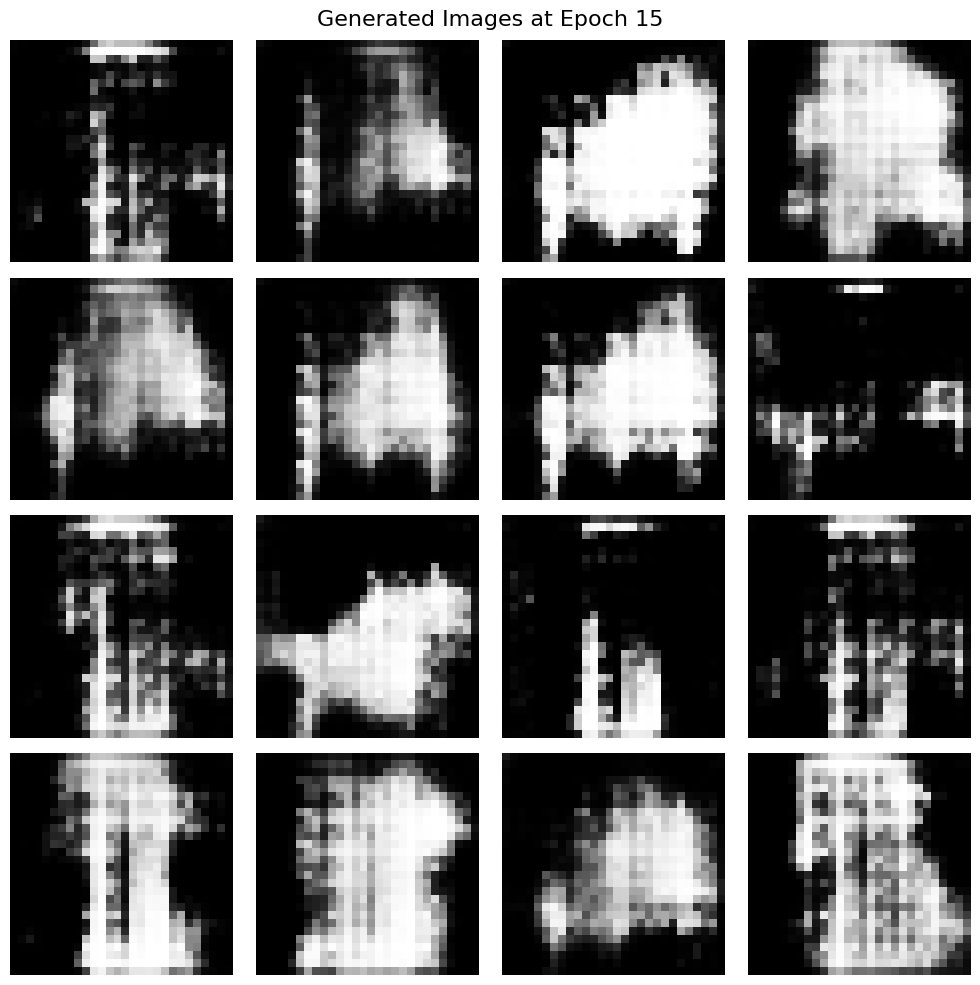

Epoch 16/50, Time: 12.48s
Generator Loss: 1.0671, Discriminator Loss: 1.1150
Epoch 17/50, Time: 12.57s
Generator Loss: 1.0611, Discriminator Loss: 1.1089
Epoch 18/50, Time: 12.67s
Generator Loss: 1.0792, Discriminator Loss: 1.0726
Epoch 19/50, Time: 12.70s
Generator Loss: 1.1894, Discriminator Loss: 0.9841
Epoch 20/50, Time: 12.66s
Generator Loss: 1.3607, Discriminator Loss: 0.9035


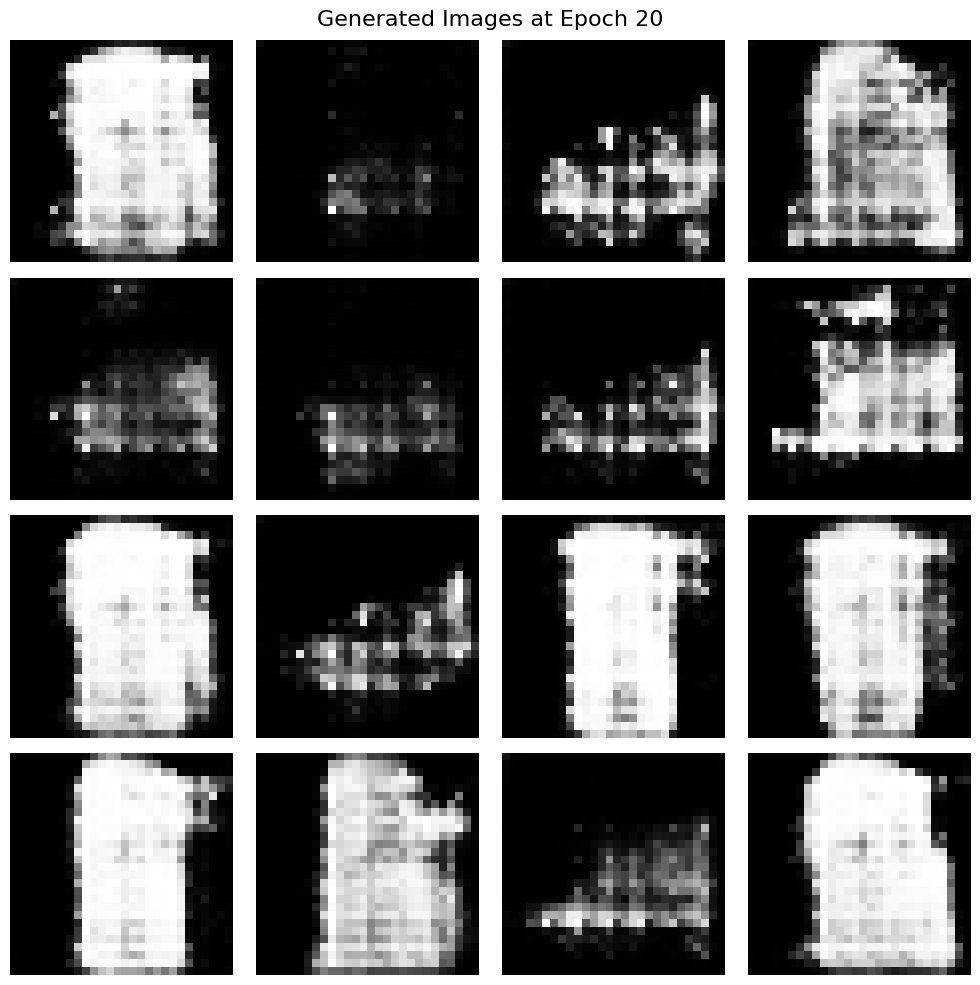

Epoch 21/50, Time: 12.57s
Generator Loss: 1.6400, Discriminator Loss: 0.7530
Epoch 22/50, Time: 12.51s
Generator Loss: 1.4581, Discriminator Loss: 0.8666
Epoch 23/50, Time: 12.55s
Generator Loss: 1.5035, Discriminator Loss: 0.7986
Epoch 24/50, Time: 12.60s
Generator Loss: 1.5901, Discriminator Loss: 0.7747
Epoch 25/50, Time: 12.66s
Generator Loss: 1.7326, Discriminator Loss: 0.7701


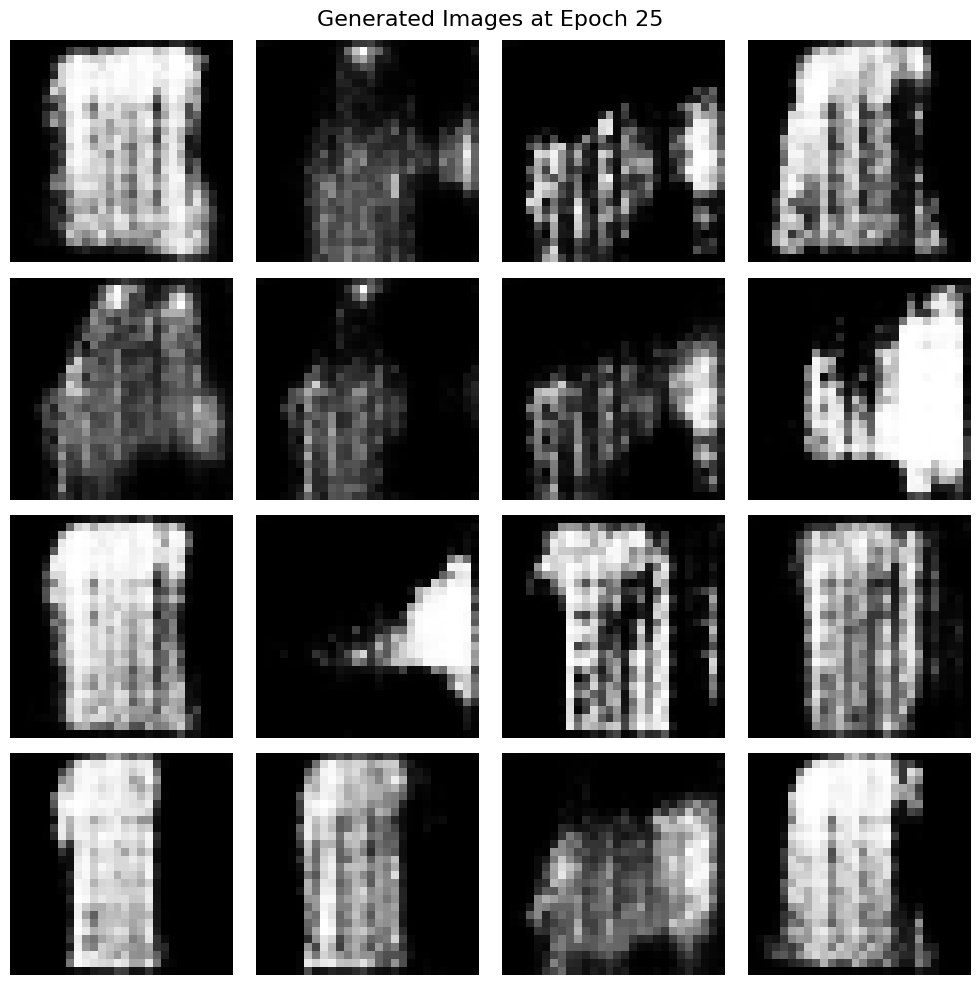

Epoch 26/50, Time: 12.63s
Generator Loss: 1.7359, Discriminator Loss: 0.7351
Epoch 27/50, Time: 12.62s
Generator Loss: 1.6173, Discriminator Loss: 0.8073
Epoch 28/50, Time: 12.61s
Generator Loss: 1.6379, Discriminator Loss: 0.8063
Epoch 29/50, Time: 12.61s
Generator Loss: 1.5224, Discriminator Loss: 0.8684
Epoch 30/50, Time: 12.59s
Generator Loss: 1.5699, Discriminator Loss: 0.8752


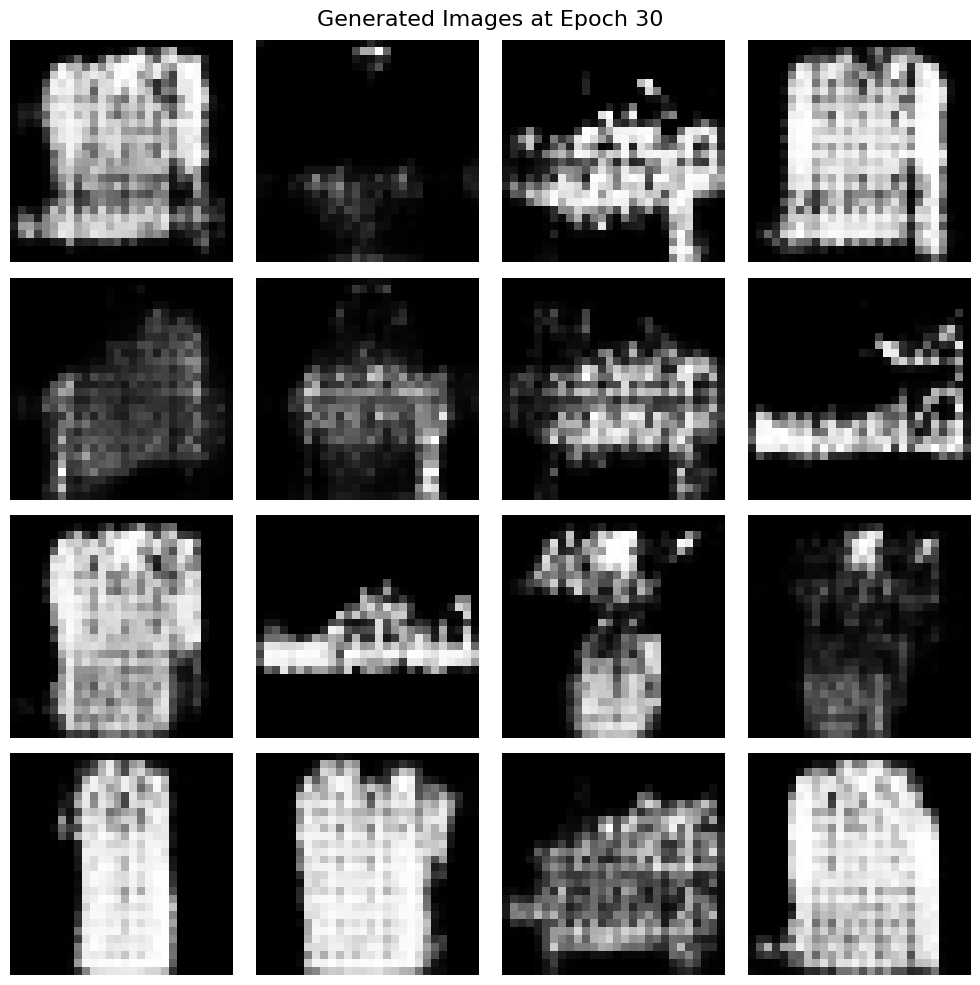

Epoch 31/50, Time: 12.58s
Generator Loss: 1.6198, Discriminator Loss: 0.8258
Epoch 32/50, Time: 12.60s
Generator Loss: 1.6880, Discriminator Loss: 0.8239
Epoch 33/50, Time: 12.60s
Generator Loss: 1.5961, Discriminator Loss: 0.7842
Epoch 34/50, Time: 12.63s
Generator Loss: 1.5495, Discriminator Loss: 0.8663
Epoch 35/50, Time: 12.63s
Generator Loss: 1.5216, Discriminator Loss: 0.8851


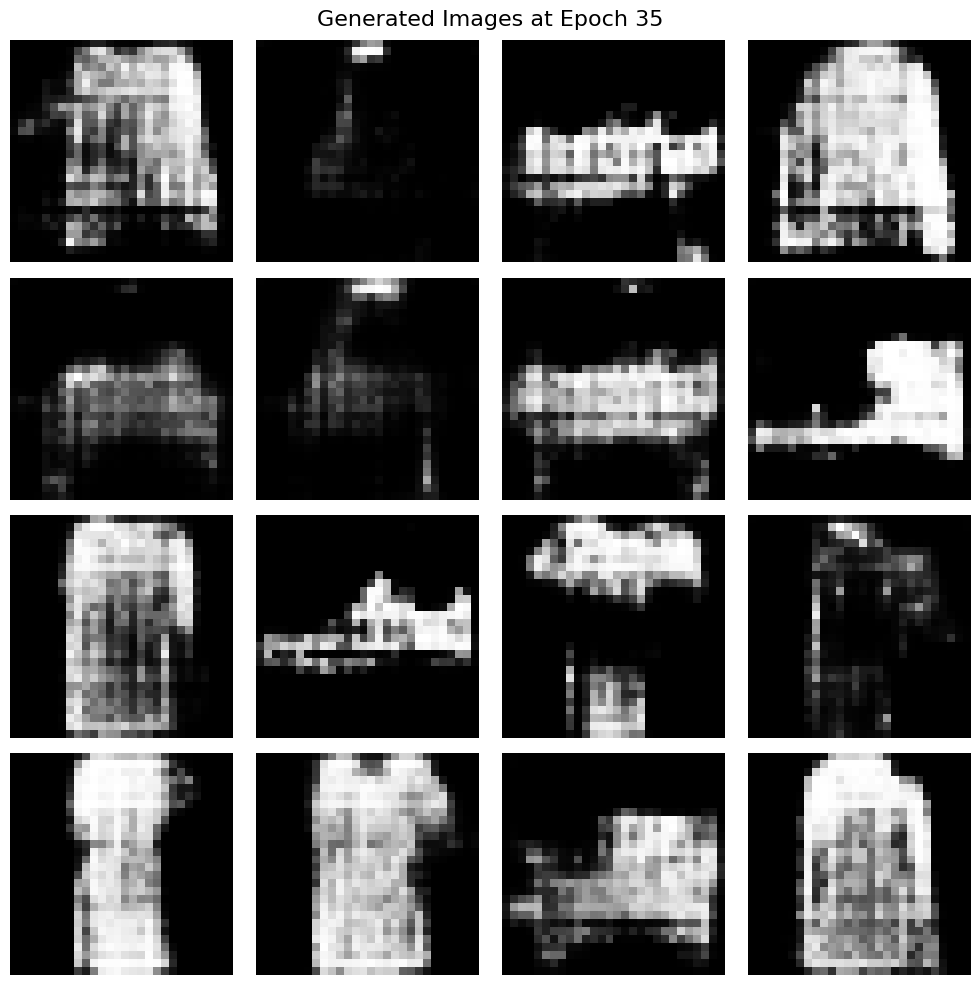

Epoch 36/50, Time: 12.63s
Generator Loss: 1.5852, Discriminator Loss: 0.8738
Epoch 37/50, Time: 12.65s
Generator Loss: 1.7020, Discriminator Loss: 0.8164
Epoch 38/50, Time: 12.64s
Generator Loss: 1.5572, Discriminator Loss: 0.8742
Epoch 39/50, Time: 12.63s
Generator Loss: 1.6545, Discriminator Loss: 0.8290
Epoch 40/50, Time: 12.64s
Generator Loss: 1.6052, Discriminator Loss: 0.8757


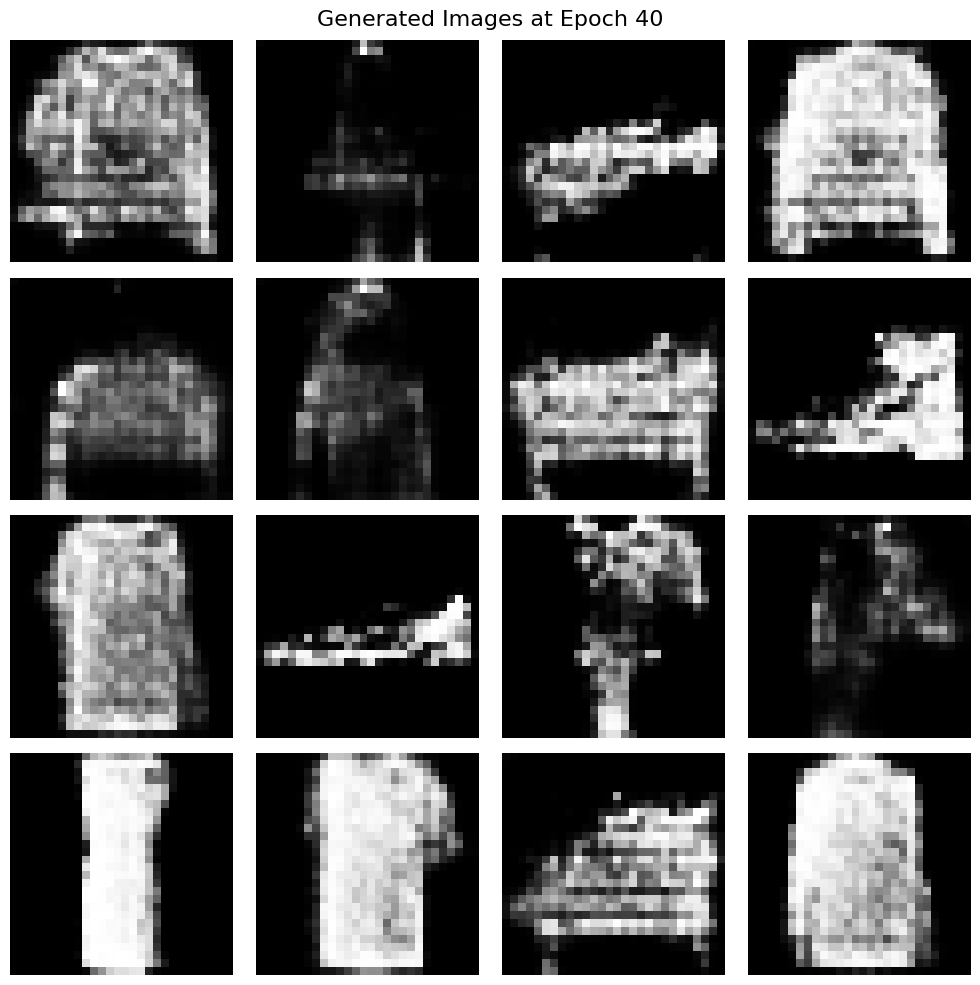

Epoch 41/50, Time: 12.61s
Generator Loss: 1.4806, Discriminator Loss: 0.9181
Epoch 42/50, Time: 12.60s
Generator Loss: 1.5230, Discriminator Loss: 0.9011
Epoch 43/50, Time: 12.61s
Generator Loss: 1.4655, Discriminator Loss: 0.9138
Epoch 44/50, Time: 12.60s
Generator Loss: 1.4192, Discriminator Loss: 0.9642
Epoch 45/50, Time: 12.61s
Generator Loss: 1.5810, Discriminator Loss: 0.8806


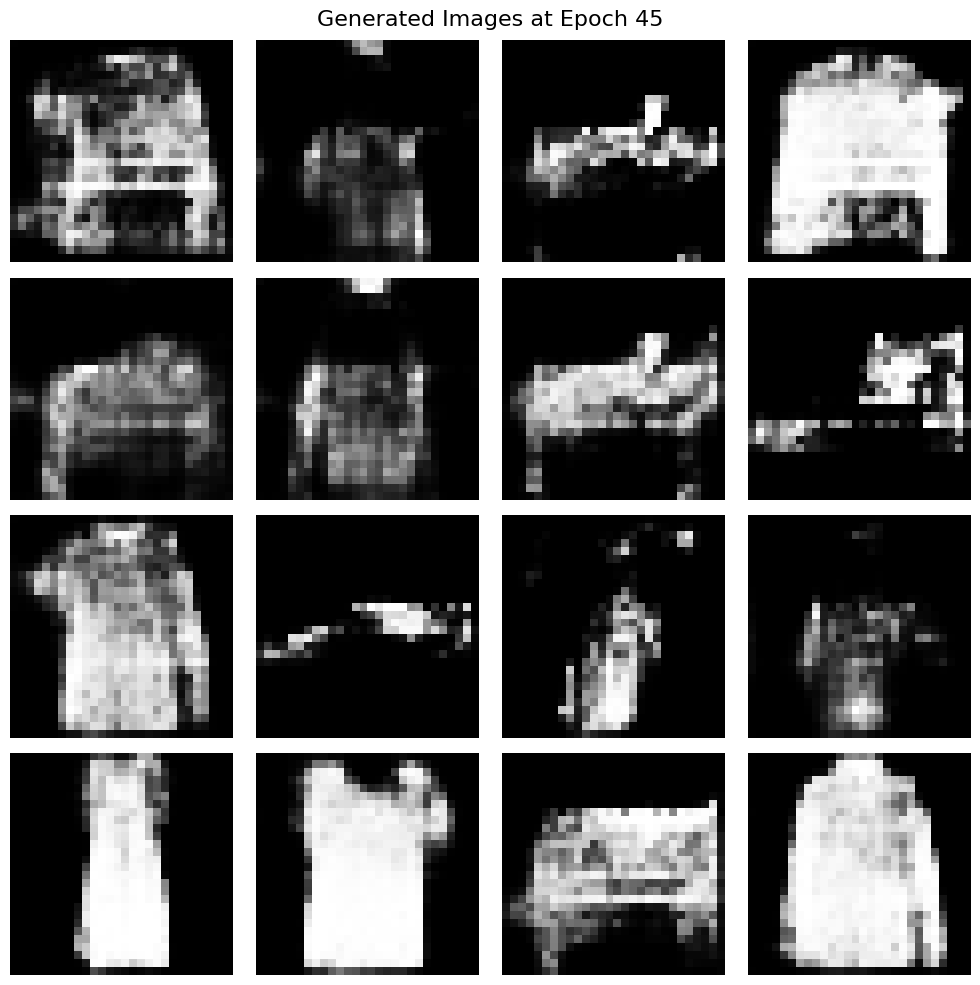

Epoch 46/50, Time: 12.59s
Generator Loss: 1.5159, Discriminator Loss: 0.9073
Epoch 47/50, Time: 12.60s
Generator Loss: 1.4299, Discriminator Loss: 0.9584
Epoch 48/50, Time: 12.59s
Generator Loss: 1.4334, Discriminator Loss: 0.9400
Epoch 49/50, Time: 12.60s
Generator Loss: 1.4408, Discriminator Loss: 0.9450
Epoch 50/50, Time: 12.60s
Generator Loss: 1.4275, Discriminator Loss: 0.9362


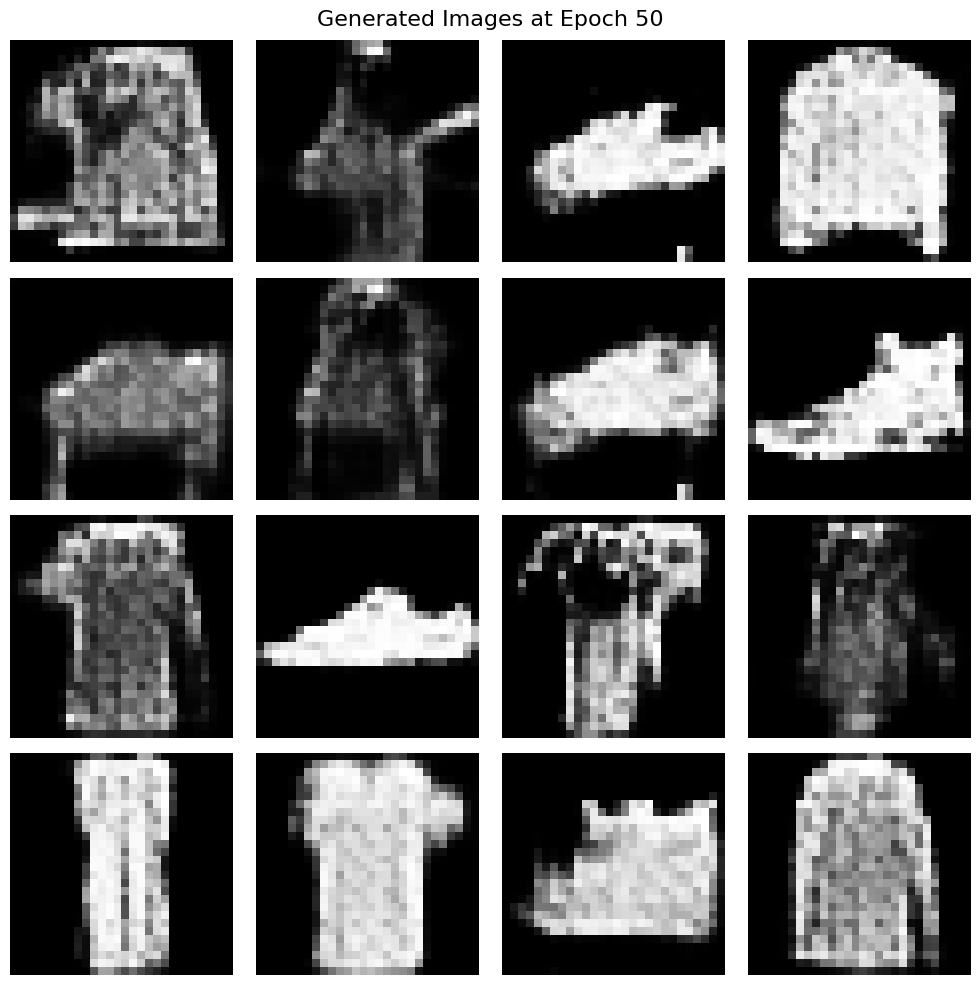

In [8]:
# Train the GAN
EPOCHS = 50
SAVE_INTERVAL = 5  # Save images every 5 epochs

# Train the model and record the losses
generator_losses, discriminator_losses = train(train_dataset, EPOCHS, SAVE_INTERVAL)

## 8. Visualize Training Progress

Now let's visualize the training progress by plotting the loss curves and comparing generated images across epochs.

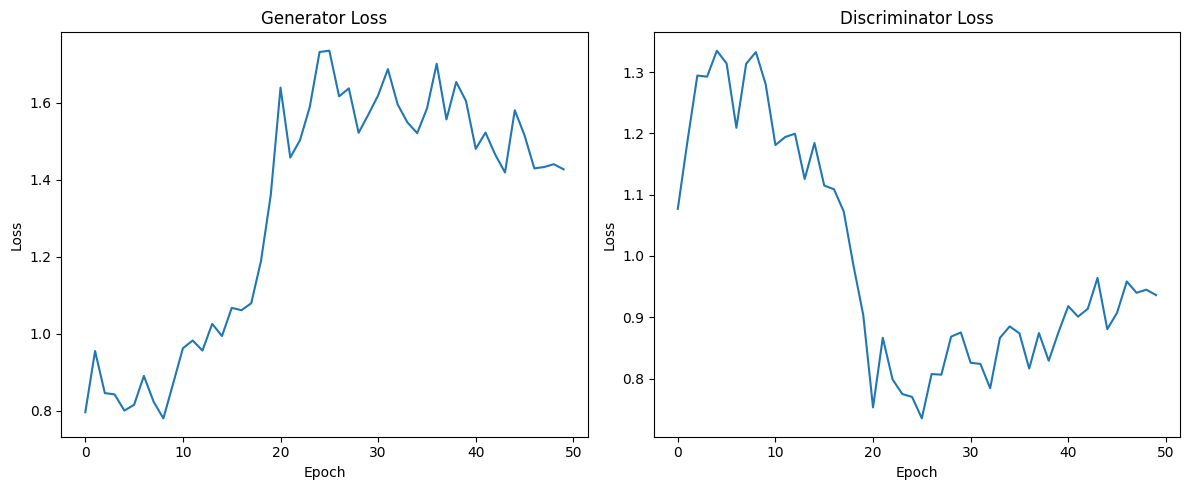

In [9]:
# Plot the loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(generator_losses)
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(discriminator_losses)
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('generated_images/loss_curves.png')
plt.show()

## 9. Generate Final Images

Generate a larger set of final images using our trained model.

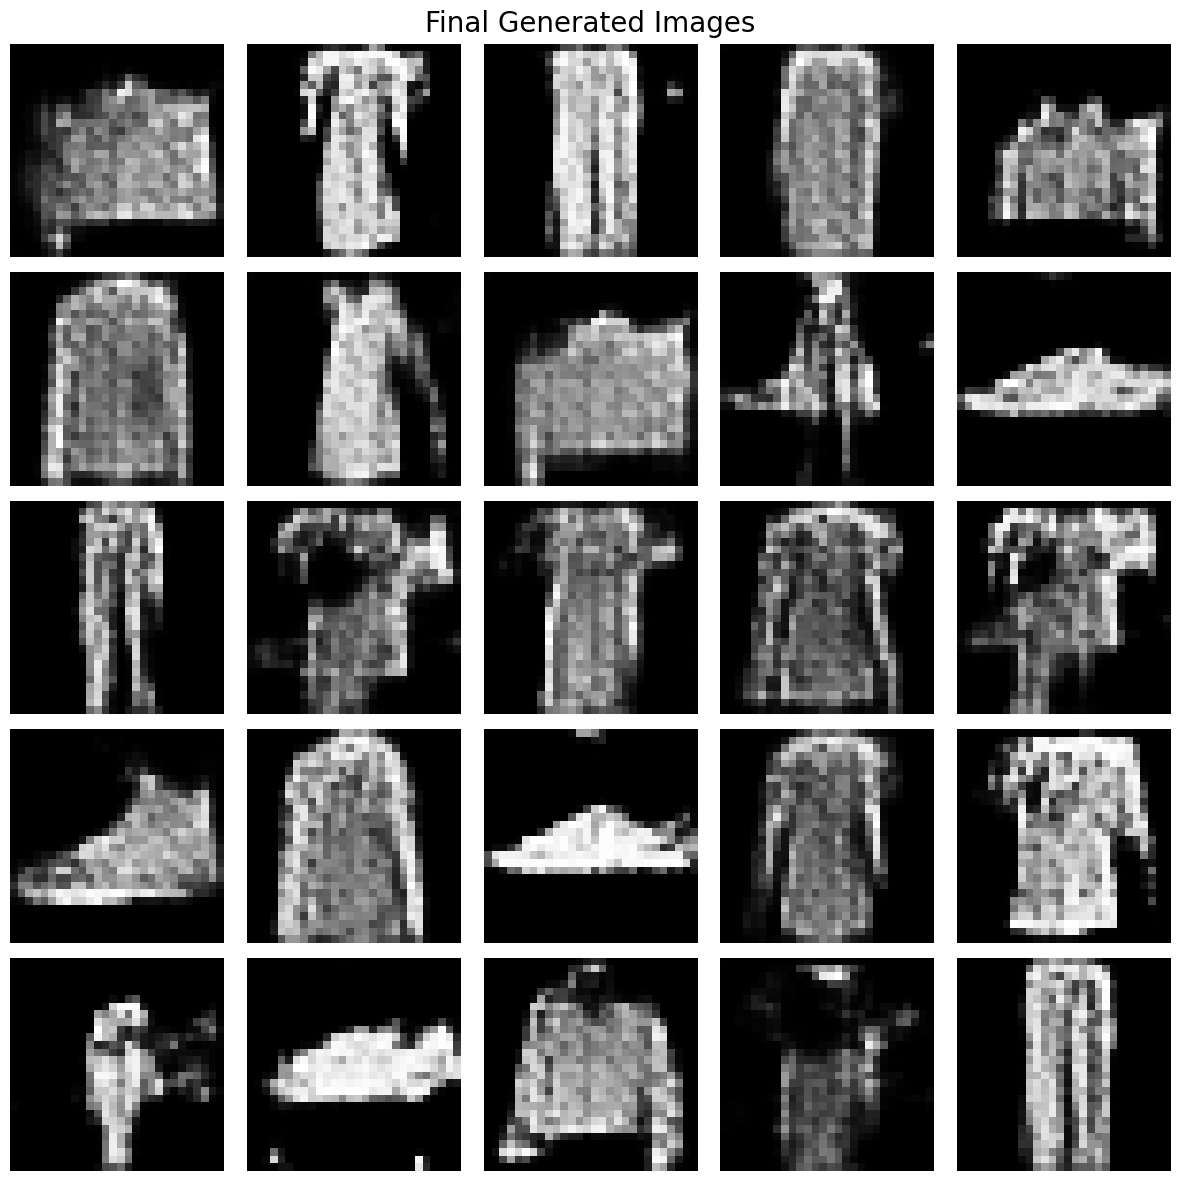

In [10]:
# Generate a larger set of final images
final_seed = tf.random.normal([25, NOISE_DIM])
final_images = generator(final_seed, training=False)

# Plot the images in a 5x5 grid
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(final_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    
plt.suptitle('Final Generated Images', fontsize=20)
plt.tight_layout()
plt.savefig('generated_images/final_images.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Create an Animation of the Generation Process

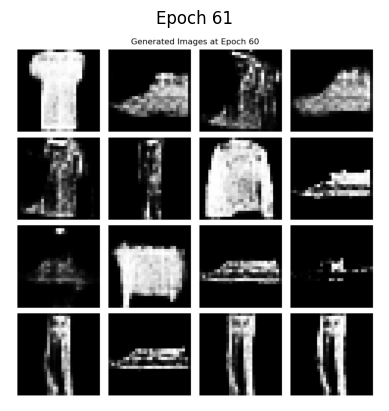

In [14]:
# Optional: Create an animation of the generation process
try:
    from IPython.display import HTML
    import matplotlib.animation as animation
    import glob
    
    # Get all the saved images
    image_files = sorted(glob.glob('generated_images/epoch_*.png'))
    
    if len(image_files) > 0:
        # Create a figure for the animation
        fig = plt.figure(figsize=(8, 8))
        
        # Function to update the figure for each frame
        def update_fig(i):
            img = plt.imread(image_files[i])
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Epoch {i*SAVE_INTERVAL+1}')
        
        # Create the animation
        anim = animation.FuncAnimation(fig, update_fig, frames=len(image_files), interval=500)
        
        # Save the animation as a gif
        anim.save('generated_images/training_progress.gif', writer='pillow', fps=2)
        
        # Display the animation
        plt.close()
        HTML(anim.to_jshtml())
    else:
        print("No saved images found for animation.")
except Exception as e:
    print(f"Could not create animation: {e}")

## 11. Save the Trained Models

In [15]:
# Save the trained models
generator.save('generated_images/generator_model.keras')
discriminator.save('generated_images/discriminator_model.keras')

print("Models saved successfully.")

Models saved successfully.


## 12. Sample Images at Different Training Stages

Here we'll load and display images from different stages of training to observe the evolution of the generator.

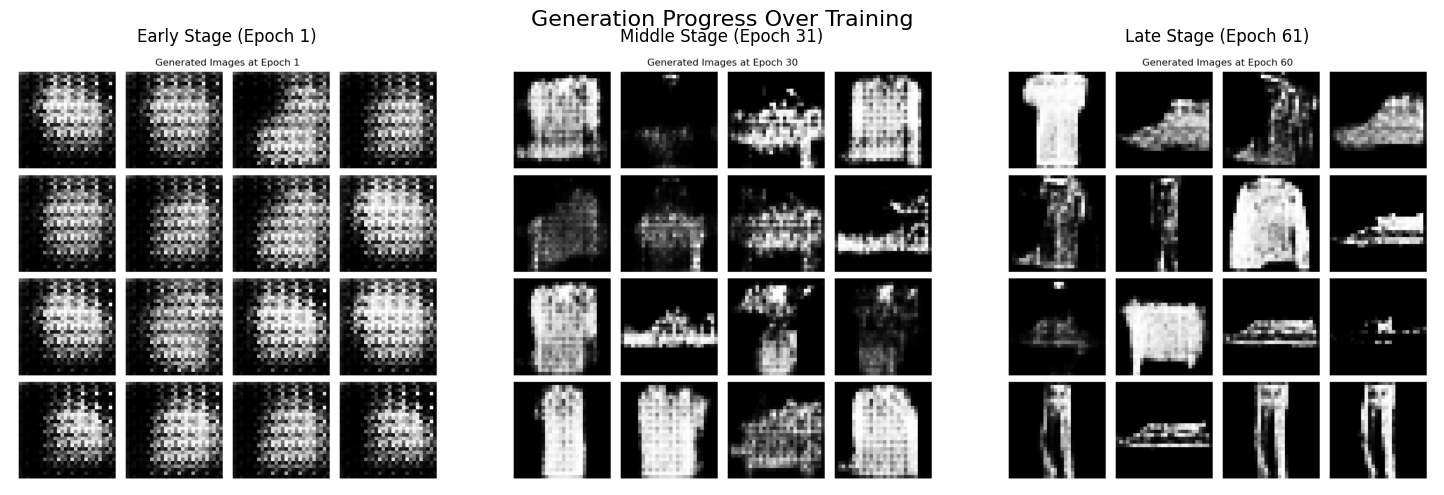

In [16]:
# Load and display images from early, middle, and late stages of training
try:
    import glob
    import matplotlib.image as mpimg
    
    # Get all image files
    image_files = sorted(glob.glob('generated_images/epoch_*.png'))
    
    if len(image_files) >= 3:
        # Select images from early, middle, and late stages
        early_idx = 0
        middle_idx = len(image_files) // 2
        late_idx = len(image_files) - 1
        
        # Load the images
        early_img = mpimg.imread(image_files[early_idx])
        middle_img = mpimg.imread(image_files[middle_idx])
        late_img = mpimg.imread(image_files[late_idx])
        
        # Display the images
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(early_img)
        plt.title(f'Early Stage (Epoch {(early_idx*SAVE_INTERVAL)+1})')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(middle_img)
        plt.title(f'Middle Stage (Epoch {(middle_idx*SAVE_INTERVAL)+1})')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(late_img)
        plt.title(f'Late Stage (Epoch {(late_idx*SAVE_INTERVAL)+1})')
        plt.axis('off')
        
        plt.suptitle('Generation Progress Over Training', fontsize=16)
        plt.tight_layout()
        plt.savefig('generated_images/training_stages_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("Not enough saved images found for comparison.")
except Exception as e:
    print(f"Could not load or display images: {e}")

## 13. Conclusion

In this notebook, we've implemented a GAN to generate realistic fashion images. The training process demonstrated how the generator learns to create increasingly realistic images over time, while the discriminator learns to distinguish between real and fake images.

### Key Achievements:
- Built a GAN architecture with generator and discriminator networks
- Implemented adversarial training with appropriate loss functions
- Visualized the training progress through generated images
- Saved models and generated images at different training stages

### Next Steps:
- Try different datasets like CIFAR-10 or CelebA for color images
- Experiment with more complex GAN architectures like DCGAN, WGAN, or StyleGAN
- Add conditional inputs to control the type of images generated
- Improve image quality with techniques like progressive growing or spectral normalization